In [1]:
import numpy as np
import imageio.v2 as imageio
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import json
import seaborn as sns

In [2]:
path_pairs = list(zip(
	natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
	natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))

In [3]:
imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

### 1) Find Contours

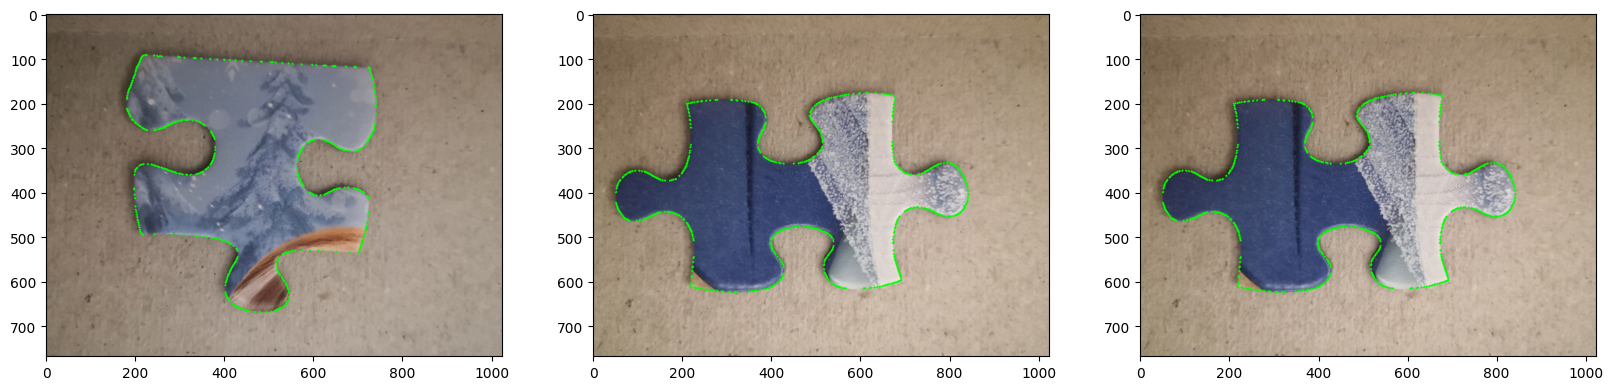

In [4]:
# Sorting contour gives weird results
# Maybe the proper shapes are actually built of many contours

#1.1
def get_puzzle_countour(mask):
    c, h = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # c = sorted(c, key=cv2.contourArea, reverse=True)[0]
    c = max(c, key = cv2.contourArea)
    return c, h

#1.2
def get_clockwise_contour(contour):
    if cv2.contourArea(contour, oriented=True) < 0:
        return contour[::-1]
    return contour

def get_oriented_contour(mask):
    c, h = get_puzzle_countour(mask.astype(np.uint8))
    c = get_clockwise_contour(c)
    return c, h

fig, axs = plt.subplots(ncols=3, figsize=(20, 20))

ims = np.random.randint(0, 45, size=3)

for i in range(3):
    c, h = get_puzzle_countour(msks[ims[i]].astype(np.uint8))
    c = get_clockwise_contour(c)
    axs[i].imshow(cv2.drawContours(imgs[ims[i]], c, -1, (0, 1, 0), 3))

plt.show()

#### Find Contours:

cv2.FindContours uses a border following technique where it traces out a sequence of coordinates of binary pixels of the same value. Using these traces, boundaries of connected regions can be determined. In the case of our mask image, the boundaries of the connected regions of 1s and 0s traces out the border of the puzzle peice. 

#### Contour Area

cv2.contourArea will visit the poijts in the contour either clockwise or anti-clockwise if it is a outer contour or inner contour respectfully. Whether it is an inner/out contour is determined in cv2.findContour. Due to how the area is calculated, visiting points in an anti-clockwise manner will result in the area being a negative value.

### 2) Shape Models

In [5]:
contours = np.array([get_oriented_contour(m)[0] for m in msks],dtype=object)

In [6]:
#2.1.1
with open('puzzle_corners_1024x768/corners.json') as f:
    names, corners = json.load(f)
    
true_corners = []
for c,target_image in zip(corners,imgs):
    temp = []

    for corner in c:
        temp.append([corner[0] * target_image.shape[1], corner[1] * target_image.shape[0]])
    true_corners.append(temp)

true_corners = np.array(true_corners)

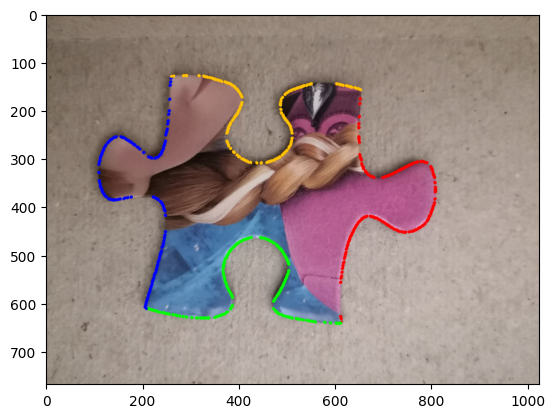

In [7]:
#2.1.2
def extract_sides(contour, corner):
	corner_indices = np.argmin(np.linalg.norm(contour - corner, axis=-1), axis=0)
	corner_indices = np.sort(corner_indices)
	sides = []

	for a in range(4):
		(i, j) = corner_indices[[a, (a+1)%4]]
		contour_new = np.roll(contour,-i,axis=0)
		sides.append(contour_new[0:j-i+1])
  
	return sides

#2.1.3
sides = extract_sides(contours[-1], true_corners[-1])

im = imgs[-1].copy()

for s, c in zip(range(4), [(1, 0, 0), (0, 1, 0), (0, 0, 1),(1, 192/255, 0)]):
	cv2.drawContours(im, sides[s], -1, c, 5)

plt.imshow(im)

#### 2.2 Normalise Sides

In [10]:
def transform_puzzle_side(contour):
	x1 = contour[0][0][0]
	y1 = contour[0][0][1]

	x2 = contour[-1][0][0]
	y2 = contour[-1][0][1]

	mx = (x1 + x2)/2
	my = (y1 + y2)/2 

	t_x = -mx
	t_y = -my

	translate = np.array([[t_x, t_y]])

	# Translation to zero centred
	for i in range(len(contour)):
		val = contour[i][0].astype(np.float32)
		val = np.squeeze(val + translate)
		
		contour[i][0] = val

	
	x1 = contour[0][0][0]
	y1 = contour[0][0][1]

	x2 = contour[-1][0][0]
	y2 = contour[-1][0][1]
	
	# sns.lineplot(x = [x1,x2], y= [y1,y2])

	angle = np.arctan2(y2 - y1, x2 - x1)
	rotate = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
	# Rotation
	for i in range(len(contour)):
		val = contour[i][0].astype(np.float32)
		val = np.matmul(rotate, val)
		contour[i][0] = val
	
		
	x1 = contour[0][0][0]
	y1 = contour[0][0][1]
	x2 = contour[-1][0][0]
	y2 = contour[-1][0][1]

	
	length = np.linalg.norm([x1-x2, y1-y2])

	for i in range(len(contour)):
		contour[i][0] = contour[i][0].astype(np.float)/float(length/2)
		
		
	x1 = contour[0][0][0]
	y1 = contour[0][0][1]

	x2 = contour[-1][0][0]
	y2 = contour[-1][0][1]

	return contour
	
sides[1] = transform_puzzle_side(sides[1].astype(np.float32).copy())


C:\Users\Matthew Dacre\AppData\Local\Temp\ipykernel_16496\1497324957.py:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contour[i][0] = contour[i][0].astype(np.float)/float(length/2)


In [15]:
#2.2.2)
def even_spaced_contour(contour, num_points=64):
	A = np.cumsum(sides[1], axis=1) / cv2.arcLength(sides[1],closed = False)
	A_x = A[:,0,0][:]
	A_y = A[:,0,1][:]
	
 
	A_x = np.append([0],A_x,axis=0)
	A_y = np.append([0],A_y,axis=0)
 
	A_new = np.linspace(0,1,num_points)
 
	B_x = sides[1][:,0,0][:]
	B_y = sides[1][:,0,1][:]
 
	B_x = np.append([0],B_x,axis=0)
	B_y = np.append([0],B_y,axis=0)
 
	B_new_x = np.interp(A_new,A_x,B_x)
	
	B_new_y = np.interp(A_new,A_y,B_y)
	
	return np.vstack((B_new_x,B_new_y)).T.reshape((-1,1,2))
 

interp_contour = even_spaced_contour(sides[1])